In [23]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
專門為pka_ver10模型設計的t-SNE可視化腳本
"""
import os, sys
from pathlib import Path
# src/extract_latent.py
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [24]:
f = '/work/u5066474/NTHU/LiveTransForM-main/OMGNN/results/pka_ver10/pka_ver10_latent_tsne_training_set_by_pka.csv'
with open(f, 'r') as fin:
    data = fin.read().splitlines()
    


In [11]:
data = np.array([i.split(',') for i in data])

In [13]:
smiles, pka, latent = data[:, 0], data[:, 1], data[:, 2:]

In [ ]:
X = latent.astype(float)
y = pka.astype(float)


print(f"運行t-SNE，特徵矩陣形狀: {X.shape}，標籤數量: {len(np.unique(y))}")

# 檢查特徵維度，如果維度太低，則進行處理
n_samples, n_features = X.shape

if n_features < 2:
    print(f"警告: 特徵維度 ({n_features}) 小於2。無法進行t-SNE降維，將直接使用原始特徵繪圖。")
    # 如果特徵維度為1，直接用該維度作為x軸，創建一個隨機噪聲作為y軸
    if n_features == 1:
        X2 = np.zeros((n_samples, 2))
        X2[:, 0] = X.flatten()  # 使用原始一維特徵作為x軸
        X2[:, 1] = 0.01 * np.random.randn(n_samples)  # 添加微小噪聲作為y軸
    else:
        X2 = X  # 這種情況不應該發生，但以防萬一
else:
    # 正常使用t-SNE降維
    tsne = TSNE(
        n_components=2,
        perplexity=min(perplexity, n_samples - 1),  # 確保perplexity不會過大
        metric=metric,
        random_state=42,
        init="pca",
    )
    X2 = tsne.fit_transform(X)


運行t-SNE，特徵矩陣形狀: (1222, 153)，標籤數量: 655


In [19]:
y

array([1.89999998, 2.75      , 3.92499995, ..., 9.06000042, 2.32999992,
       4.13000011])

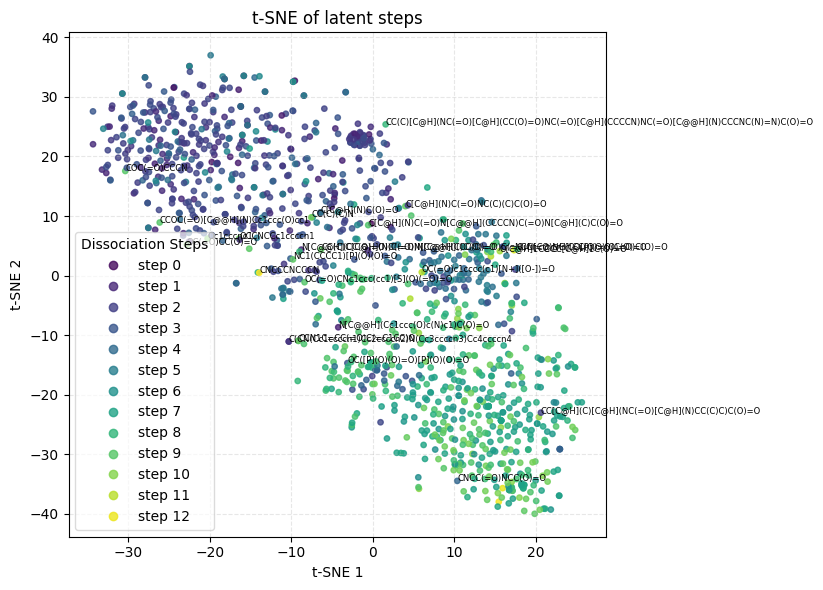

'\nX, y_pka = collect_latent_with_pka(model, test_loader, device)\n\ntsne_and_plot(\nX              = X,\ny              = y_pka,               # 直接拿 pKa 當 color\ntitle          = f"t-SNE – {version} (colored by pKa)",\nsave_png       = f"{version}_latent_tsne_pka.png",\nperplexity     = 30,\nmetric         = "cosine",\ncolormap       = "viridis",           # 選連續色譜\ncolorbar_label = "experimental pKa"   # 只要非 None → 顯示 color-bar\n)\n'

In [51]:
title = "t-SNE of latent steps"
save_png=None
perplexity=30
metric="cosine"
colormap="viridis"
colorbar_label=None

# 創建散點圖
outlier_smiles_and_neighbours = []
plt.figure(figsize=(8, 6))
sc = plt.scatter(X2[:,0], X2[:,1], c=y, s=15, cmap=colormap, alpha=0.8)
for i, X2_ in enumerate(X2):
    pka_value = y[i]
    smiles_ = smiles[i]
    X_se = np.sum((X2 - X2_) ** 2, axis=1)
    chosen = np.argsort(X_se)[1:6]
    pka_value_nei = y[chosen].mean()
    if np.abs(pka_value_nei - pka_value) > 5:
        plt.text(X2_[0], X2_[1], f"{smiles_}", fontsize=6)
        outlier_smiles_and_neighbours.append([smiles_] + smiles[chosen[:3]].tolist() + [pka_value])
plt.title(title)

# 檢查是否為連續值 (如 pKa) 還是離散類別 (如步驟)
if colorbar_label is not None:
    # 連續值著色 - 顯示顏色條
    cbar = plt.colorbar(sc)
    cbar.set_label(colorbar_label)
else:
    # 離散類別著色 - 顯示圖例
    handles, labels = sc.legend_elements()
    step_labels = [f"step {i}" for i in range(len(handles))]
    plt.legend(handles, step_labels, title="Dissociation Steps", loc="best", 
                fontsize=10, framealpha=0.7)

# 添加軸標籤
plt.xlabel("t-SNE 1" if n_features >= 2 else "Feature 1")
plt.ylabel("t-SNE 2" if n_features >= 2 else "Noise")

# 添加網格線
plt.grid(alpha=0.3, linestyle="--")

plt.tight_layout()

# 保存或顯示圖像
if save_png:
    plt.savefig(save_png, dpi=300, bbox_inches="tight")
    print(f"圖像已保存 → {save_png}")
else:
    plt.show()

# 示例使用方法 (可以添加為註釋)
"""
X, y_pka = collect_latent_with_pka(model, test_loader, device)

tsne_and_plot(
X              = X,
y              = y_pka,               # 直接拿 pKa 當 color
title          = f"t-SNE – {version} (colored by pKa)",
save_png       = f"{version}_latent_tsne_pka.png",
perplexity     = 30,
metric         = "cosine",
colormap       = "viridis",           # 選連續色譜
colorbar_label = "experimental pKa"   # 只要非 None → 顯示 color-bar
)
""" 

In [52]:
import pandas as pd
df = pd.DataFrame(outlier_smiles_and_neighbours)

In [53]:
df.columns = ["smiles", "neighbour_1", "neighbour_2", "neighbour_3", "pka"]

In [54]:
from rdkit import Chem
# import pandastools from rdkit
from rdkit.Chem import PandasTools
# pandastools add mol to dataframe
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="smiles", molCol="mol_smiles")
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="neighbour_1", molCol="mol_neighbour_1")
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="neighbour_2", molCol="mol_neighbour_2")
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="neighbour_3", molCol="mol_neighbour_3")
# df.head()
fdir = "/work/u5066474/NTHU/LiveTransForM-main/OMGNN/results/pka_ver10/outlier_smiles_and_neighbours.html"
df.to_html(fdir, index=False)
# df.to_csv("outlier_smiles_and_neighbours.csv", index=False)


# 對Outlier做分析

In [1]:
import pandas as pd
df = pd.read_csv(f'../results/pka_ver10/pka_combined_prediction_pka_ver10.csv')
# df.head()
smiles_to_remove = df[df['functional_group'].isin(['SulfonicAcid', 'Phosphate', 'PhosphonicAcid', 'ImidazoleLike'])].smiles.unique()
df = df[~df['smiles'].isin(smiles_to_remove)]

In [2]:
df['difference_largest'] = df.groupby('smiles')['difference'].transform('max')

In [3]:
sorted_df = df.sort_values(by=['difference_largest', 'smiles'], ascending=[True, True])

In [4]:
sorted_df.to_csv(f'../results/pka_ver10/pka_combined_prediction_pka_ver10_sorted.csv', index=False)

In [5]:
from rdkit import Chem
# import pandastools from rdkit
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(sorted_df, smilesCol="smiles", molCol="mol_smiles")
fdir = "pka_ver10_sorted.html"
sorted_df.to_html(fdir, index=False)

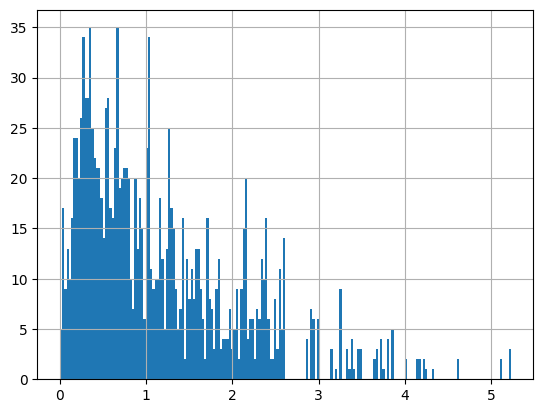

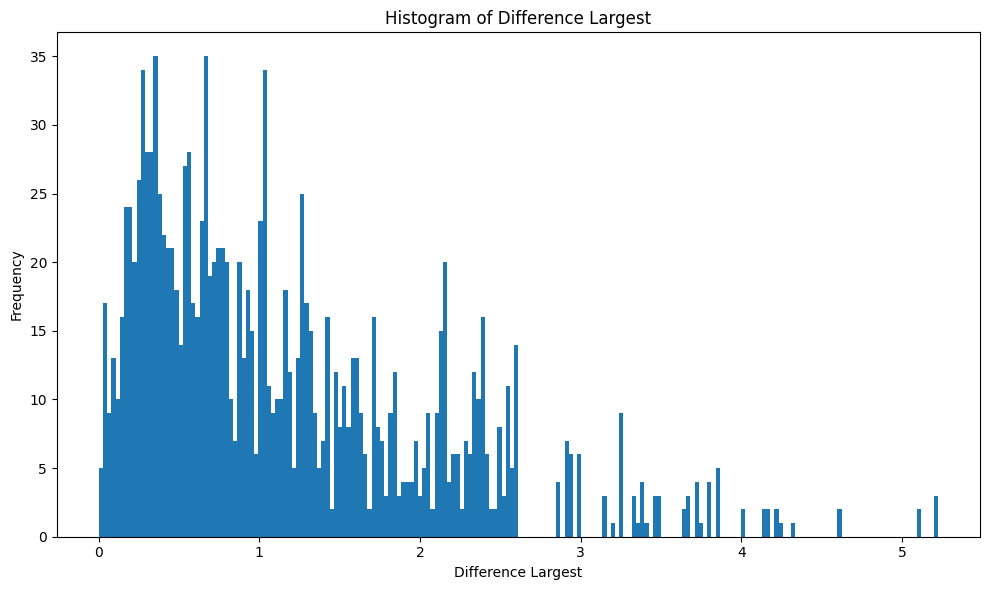

In [ ]:
sorted_df['difference_largest'].hist(bins=200)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(sorted_df['difference_largest'], bins=200)
plt.xlabel('Difference Largest')
plt.ylabel('Frequency')
plt.title('Histogram of Difference Largest')
plt.tight_layout()
plt.show()

In [21]:
df_outlier = sorted_df[(sorted_df['difference_largest'] > 2.7)]
# df_outlier = sorted_df[(sorted_df['difference_largest'] > 2.7) & (sorted_df['is_train'] == True)]
df_outlier.head(20)

,molecule_name,smiles,true_pos,pred_pos,true_pka,predicted_pka,difference,is_train,functional_group,difference_largest,mol_smiles
1401,test_Molecule_608,Nc1nc(N)c2[nH]cnc2n1,2,NaN,4.89,NaN,NaN,False,NaN,5.223900,<rdkit.Chem.rdchem.Mol object at 0x1491fb586c10>
1402,test_Molecule_608,Nc1nc(N)c2[nH]cnc2n1,0,NaN,10.37,NaN,NaN,False,Aniline,5.223900,<rdkit.Chem.rdchem.Mol object at 0x1491fb586b30>
1403,test_Molecule_608,Nc1nc(N)c2[nH]cnc2n1,4,4.0,10.37,5.146100,5.223900,False,Aniline,5.223900,<rdkit.Chem.rdchem.Mol object at 0x1491fb586dd0>
937,train_Molecule_577,OC1=C(O)C(=O)C(=O)C1=O,0,0.0,0.60,5.704341,5.104341,True,Phenol,5.104341,<rdkit.Chem.rdchem.Mol object at 0x1491fad73430>
938,train_Molecule_577,OC1=C(O)C(=O)C(=O)C1=O,3,3.0,1.80,5.704341,3.904341,True,Phenol,5.104341,<rdkit.Chem.rdchem.Mol object at 0x1491fad734a0>
1279,test_Molecule_638,CCCCCCN1C=CC(=O)C(=C1C)O,6,6.0,3.59,8.198402,4.608402,False,Pyridine,4.608402,<rdkit.Chem.rdchem.Mol object at 0x1491fad73510>
1280,test_Molecule_638,CCCCCCN1C=CC(=O)C(=C1C)O,14,14.0,9.92,7.416578,2.503422,False,Phenol,4.608402,<rdkit.Chem.rdchem.Mol object at 0x1491fad73580>
828,train_Molecule_129,OC1=CC(=O)Oc2ccccc12,0,0.0,4.06,8.374475,4.314475,True,Phenol,4.314475,<rdkit.Chem.rdchem.Mol object at 0x1491fad73660>
279,train_Molecule_167,Nc1ccncc1,0,0.0,9.17,4.918562,4.251438,True,Aniline,4.251438,<rdkit.Chem.rdchem.Mol object at 0x1491fad810b0>
24,train_Molecule_597,CCN1C=CC(=O)C(=C1C)O,2,2.0,3.64,7.867666,4.227666,True,Pyridine,4.227666,<rdkit.Chem.rdchem.Mol object at 0x1491fad81120>


In [22]:
len(df_outlier['smiles'].unique())


33

In [17]:
df_raw = pd.read_csv(f'/work/u5066474/NTHU/LiveTransForM-main/OMGNN/output/pka_mapping_results.csv')
df_raw.head()

,smiles,pka_values,functional_groups,mapping,pka_matrix
0,Sc1ccccc1,[6.46],"[{'type': 'Thiol', 'indices': [0]}]","{'6.46': {'type': 'Thiol', 'indices': [0]}}","[(0, 6.46)]"
1,[Cl-].Cc1ncc(C[n+]2csc(CCO)c2C)c(N)n1,[4.79],"[{'type': 'Aniline', 'indices': [17]}]","{'4.79': {'type': 'Aniline', 'indices': [17]}}","[(17, 4.79)]"
2,[O-][N+](=O)c1cc2cccnc2c3ncccc13,[3.22],"[{'type': 'Pyridine', 'indices': [9]}, {'type'...","{'3.22': {'type': 'Pyridine', 'indices': [9]}}","[(9, 3.22)]"
3,[O-][N+](=O)c1ccc(O[P](O)(O)=O)cc1,[5.015],"[{'type': 'PhosphonicAcid', 'indices': [9]}, {...","{'5.015': {'type': 'PhosphonicAcid', 'indices'...","[(9, 5.015)]"
4,[O-][n+]1ccccc1S,[4.43],"[{'type': 'Thiol', 'indices': [7]}, {'type': '...","{'4.43': {'type': 'Pyridine', 'indices': [1]}}","[(1, 4.43)]"


In [18]:
df_raw_remove_outlier = df_raw[~df_raw['smiles'].isin(df_outlier['smiles'].unique())]
df_raw_remove_outlier.head()
len(df_raw_remove_outlier['smiles'].unique())
df_raw_remove_outlier.to_csv(f'/work/u5066474/NTHU/LiveTransForM-main/OMGNN/output/pka_mapping_results_remove_outlier.csv', index=False)


In [1]:
import pandas as pd
df_valid = pd.read_csv(f'../results/pka_ver19/pka_combined_pka_ver19.csv')

In [3]:
from ast import literal_eval
import numpy as np
true_lists = df_valid["true_pka"].apply(literal_eval)
pred_lists = df_valid["pred_pka"].apply(literal_eval)
true_pka = np.concatenate(true_lists)
pred_pka = np.concatenate(pred_lists)

In [7]:
true_pka = pd.DataFrame(true_pka, columns=['true_pka'])

array([[<Axes: title={'center': 'true_pka'}>]], dtype=object)

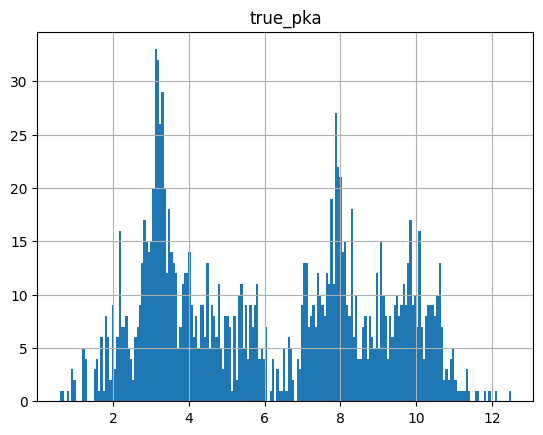

In [8]:
true_pka.hist(bins=200)
# pred_lists.hist(bins=200)


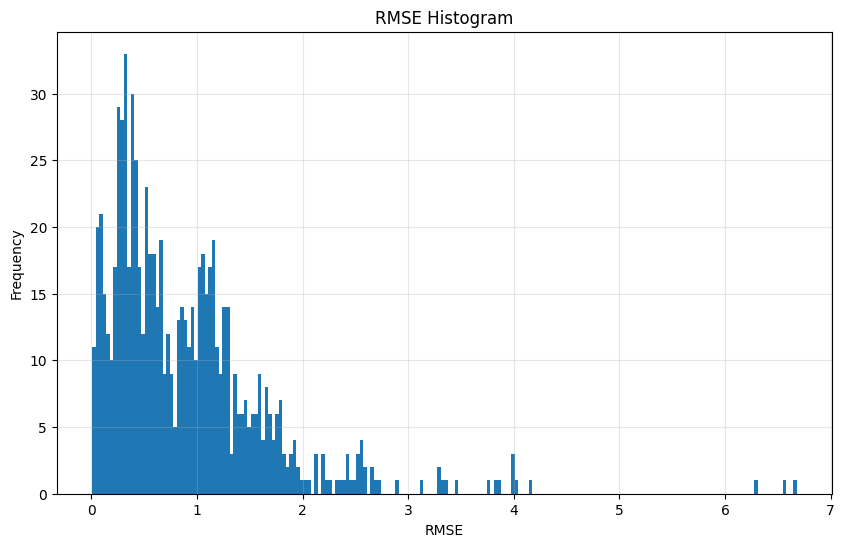

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
df_valid['rmse'].hist(bins=200)
plt.title('RMSE Histogram')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
